# 2nd version MNIST CBE-ANN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
Train = False

# Load dataset and model

In [3]:
(ds_test, ds_val, ds_train), ds_info = tfds.load(
    'mnist',
    split=['train[:10%]','train[10%:25%]','train[25%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    return tf.cast(image, tf.float32) / 255., label

# normalize dataset parts
ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)
ds_val = ds_val.map(normalize_img)

In [4]:
model = tf.keras.models.load_model('../modelmnist')

In [5]:
if Train == True:
    model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    )

In [6]:
images_tr = [elem[0] for elem in ds_train.as_numpy_iterator()]
labels = [elem[1] for elem in ds_train.as_numpy_iterator()]
images_tr = np.stack(images_tr[:150])
labels = np.array(labels)

image_list = [elem[0] for elem in ds_test.as_numpy_iterator()]
labels_list = [elem[1] for elem in ds_test.as_numpy_iterator()]
image_list = np.stack(image_list)
labels_list = np.array(labels_list)

targets_train = model.predict(images_tr)
reduced_targets_train = targets_train[:150]

In [7]:
print(images_tr.shape)
print(targets_train.shape)

(150, 28, 28, 1)
(150, 10)


# Select input

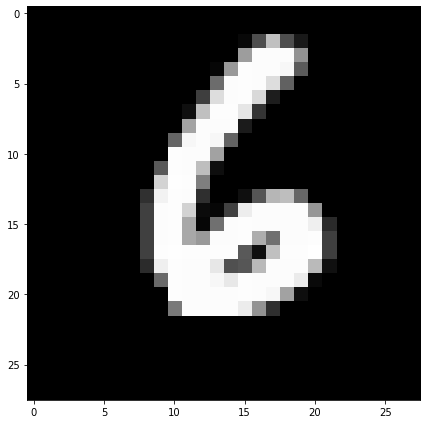

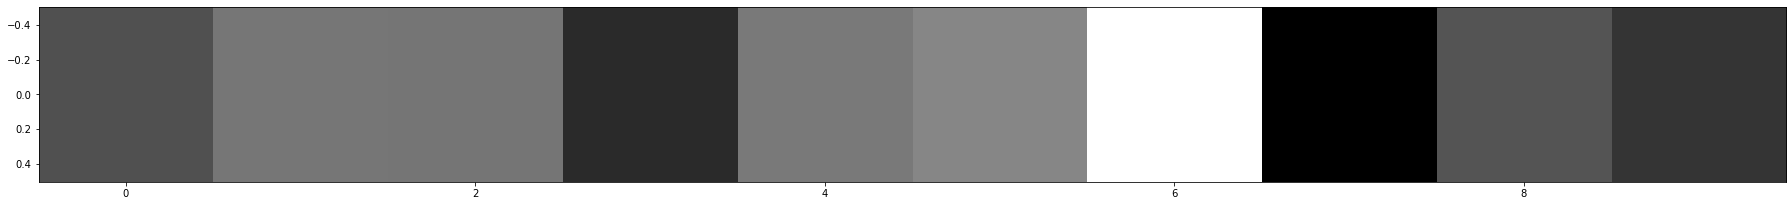

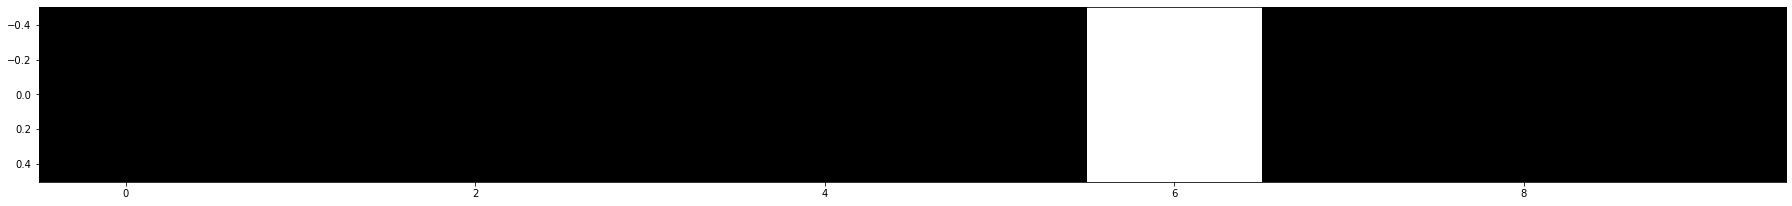

In [43]:
indice_input = 9
inputs = image_list[indice_input]

plt.imshow(inputs, cmap='gray')
plt.show()

inputs = np.expand_dims(inputs,0)
targets = model.predict(inputs)
strict_targets = (targets == np.max(targets)).astype(int)
plt.imshow(targets, cmap='gray')
plt.show()
plt.imshow(strict_targets, cmap='gray')
plt.show()

# Import method

In [44]:
#from CaseBasedExplainer import CaseBasedExplainer
from xplique.plots import plot_attributions
from xplique.plots.image import _standardize_image
from xplique.attributions import Occlusion
from xplique.types import Callable, Tuple, Union, Optional
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KDTree

In [53]:
class CaseBasedExplainer():
    """
    TODO
    
    Used to compute the Case Based Explainer sytem, a twins sytem that use ANN and KNN with
    the same dataset.
    
    Ref. Twin-Systems to Explain Artificial Neural Networks using Case-Based Reasoning:
            Comparative Tests of Feature-Weighting Methods in ANN-CBR Twins for XAI.
            Eoin M. Kenny and Mark T. Keane.
            
    """

    def __init__(self,
                 model: Callable,
                 case_dataset: Union[tf.data.Dataset, tf.Tensor, np.ndarray],
                 targets: Union[tf.Tensor, np.ndarray],
                 batch_size: Optional[int] = 16,
                 distance_function: DistanceMetric = None,
                 weights_extraction_function: Callable = None,
                 k: Optional[int] = 3):
        """
        Parameters
        ----------

        model
            The model from wich we want to obtain explanations
        case_dataset
            The dataset used to train the model, also use by the function to calcul the closest examples.
        targets
            labels predict by the model from the dataset
        batch_size
            Number of pertubed samples to explain at once.
            Default = 16
        distance_function
            The function to calcul the distance between the inputs and all the dataset.
            (Can use : euclidean, manhattan, minkowski etc...)
        weights_extraction_function
            The function to calcul the weight of every features, many type of methode can be use but it will depend of
            what type of dataset you've got.
        k
            Represante how many nearest neighbours you want to be return.
        """
        # set attributes
        self.model = model
        self.batch_size = batch_size
        self.case_dataset = case_dataset
        self.weights_extraction_function = weights_extraction_function
        self.k = k
        
        # compute case dataset weights (used in distance)
        # the weight extraction function may need the prediction to extract the weights
        case_dataset_weight = self.weights_extraction_function(case_dataset, targets)
        case_dataset_weight = np.expand_dims(case_dataset_weight, 3)
        self.case_dataset_weight = case_dataset_weight

        # apply weights to the case dataset
        weighted_case_dataset = tf.math.multiply(case_dataset_weight, case_dataset)
        # flatten features for kdtree
        weighted_case_dataset = tf.reshape(weighted_case_dataset, [weighted_case_dataset.shape[0], -1])

        # create kdtree instance with weighted case dataset
        # will be called to estimate closest examples
        self.Knn = KDTree(weighted_case_dataset, metric = 'euclidean')

    def explain(self,
                inputs: Union[tf.Tensor, np.ndarray],
                targets: Union[tf.Tensor, np.ndarray] = None):
        """
        Parameters
        ----------
        inputs
            Tensor or Array. Input samples to be explained.
            Expected shape among (N,T,W), (N,W,H,C).
        targets
            Tensor or Array. Corresponding to the prediction of the samples by the model.
            shape: (n, nb_classes)
            Used by the `weights_extraction_function` if it is an Xplique attribution function,
            For more details, please refer to the explain methods documentation   
            
        Returns
        -------
        examples 
            Represente the K nearust neighbours of the input.
        distance
            distance between the input and the examples.
        weight
            features weight of the inputs
        """
        # compute weight (used in distance)
        # the weight extraction function may need the prediction to extract the weights
        weights = self.weights_extraction_function(inputs, targets)
        weights = np.expand_dims(weights, 3)
        
        # apply weights to the inputs
        weighted_inputs = tf.math.multiply(weights, inputs)
        # flatten features for knn query
        weighted_inputs = tf.reshape(weighted_inputs, [weighted_inputs.shape[0], -1])
        
        # kdtree instance call with knn.query,
        # call with the weighted inputs and the number of closest examples (k)
        examples_distance , examples_indice = self.Knn.query(weighted_inputs, k = self.k)
        
        # extraction of the examples by their indice
        self.examples_indice = examples_indice[0]
        examples = []
        for i in self.examples_indice:
            examples.append(self.case_dataset[i])
        
        # TODO
        examples_distance = examples_distance[0]
        
        return examples, examples_distance, weights
    
    
    def showResult(self,
                   inputs: Union[tf.Tensor, np.ndarray],
                   dist: float,
                   weight: np.ndarray,
                   indice_original: int,
                   labels_train: np.ndarray,
                   labels_test: np.ndarray,
                   clip_percentile: Optional[float] = 0.2,
                   cmapimages: Optional[str] = "gray",
                   cmapexplanation: Optional[str] = "coolwarm",
                   alpha: Optional[float] = 0.5):
        """
        Parameters
        ---------
        inputs
            Tensor or Array. Input samples to be show next to examples.
            Expected shape among (N,T,W), (N,W,H,C).
        distance
            Distance between input data and examples.    
        weight
            features weight of the inputs 
        indice_original
            Represente the indice of the inputs to show the true labels
        labels_train
            Corresponding to the train labels dataset   
        labels_test
            Corresponding to the test labels dataset
        clip_percentile
            Percentile value to use if clipping is needed, e.g a value of 1 will perform a clipping
            between percentile 1 and 99. This parameter allows to avoid outliers  in case of too extreme values.
        cmapimages
            For images.
            The Colormap instance or registered colormap name used to map scalar data to colors.
            This parameter is ignored for RGB(A) data.
        cmapexplanation
            For explanation.
            The Colormap instance or registered colormap name used to map scalar data to colors.
            This parameter is ignored for RGB(A) data.
        alpha
            The alpha blending value, between 0 (transparent) and 1 (opaque).
            If alpha is an array, the alpha blending values are applied pixel by pixel, 
            and alpha must have the same shape as X.
        """ 
        
        # Initialize 'input_and_examples' and 'corresponding_weights' that they
        # will be use to show every closest examples and the explanation
        input_and_examples = [inputs]
        corresponding_weights = [weight]
        # list creation of the examples and weights
        for i in self.examples_indice:
            example = tf.expand_dims(self.case_dataset[i], 0)
            example_weights = tf.expand_dims(self.case_dataset_weight[i], 0)
            input_and_examples.append(example)
            corresponding_weights.append(example_weights)
        # concatanation of those list
        input_and_examples = tf.concat(input_and_examples, axis = 0)
        corresponding_weights = tf.concat(corresponding_weights, axis = 0)
        
        # calcul the prediction of input and examples 
        # that they will be used at title of the image
        predictions = self.model.predict(input_and_examples)
        predicted_labels = tf.argmax(predictions, axis = 1)

        # configure the grid to show all results
        plt.rcParams["figure.autolayout"] = True
        plt.rcParams["figure.figsize"] = [25, 6]
        fig = plt.figure()
        gs = fig.add_gridspec(2, len(input_and_examples) * 2)
        
        # loop to organize and show all results
        for j in  range(len(input_and_examples)):
            ax = fig.add_subplot(gs[0, j])
            if j == 0:
                plt.title(f'Original image\nGround Truth: {labels_test[indice_original]}\nPredict: {predicted_labels[j]}')
            else:
                plt.title(f'K-nearest neighbours\nGround Truth: {labels_train[self.examples_indice[j-1]]}\nPredict: {predicted_labels[j]}')
            plt.imshow(input_and_examples[j], cmap = cmapimages)
            plt.axis("off")
            ax2 = fig.add_subplot(gs[1, j])
            plt.imshow(input_and_examples[j], cmap = cmapimages)
            plt.imshow(_standardize_image(corresponding_weights[j], clip_percentile), cmap = cmapexplanation, alpha = alpha)
            plt.axis("off")
        plt.show()


# Use the method

In [50]:
weights_extraction_function = Occlusion(model,patch_size=(4, 4), patch_stride=(2, 2),batch_size=16, occlusion_value=0).explain
distance_function = DistanceMetric.get_metric('euclidean')

explainer = CaseBasedExplainer(model,
                               images_tr,
                               targets_train,
                               distance_function = distance_function,
                               weights_extraction_function = weights_extraction_function,
                               k = 5)

C:\Users\adelin.constans\Anaconda3\envs\tfearly\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [51]:
examples, examples_dist, weight = explainer.explain(inputs, targets)
#print(examples)
print(examples_dist)
#print(weight)

[3441.4978926  4474.52990829 4584.44950864 4849.74051815 5178.3730759 ]


# Show Result

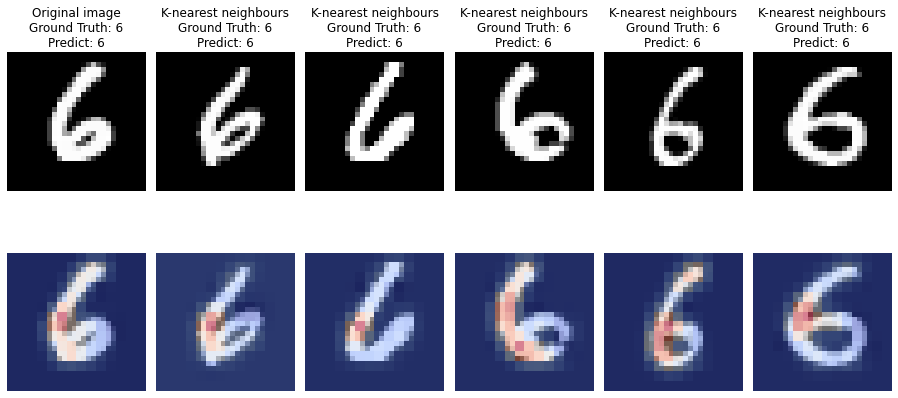

In [52]:
explainer.showResult(inputs, examples_dist, weight, indice_input, labels, labels_list) 